In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from matplotlib.colors import Normalize
import sys

In [135]:
def print_progress_bar(iteration, total, prefix='', suffix='', decimals=1, length=50, fill='█'):
    """
    Call in a loop to create a terminal progress bar.
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filled_length = int(length * iteration // total)
    bar = fill * filled_length + '-' * (length - filled_length)
    sys.stdout.write(f'\r{prefix} |{bar}| {percent}% {suffix}')
    sys.stdout.flush()
    # Print New Line on Complete
    if iteration == total: 
        print()

#### DLA

In [101]:
def diffusion_SOR(initial_grid, grid_size, objects, tol=1e-5, omega=1.8, max_iter=10000):
    """
    Simulate the 2D diffusion using the Successive Over Relaxation (SOR) method with a stopping condition.

    # parllelize the SOR to speed up the simulation

    :param initial_grid: The initial grid concentration.
    :param epsilon: The convergence criterion.
    :param omega: The relaxation parameter for SOR.
    """
    c = np.zeros((len(initial_grid), len(initial_grid)))
    c[:,:] = initial_grid # Initial condition at t=0

    for k in range(1, max_iter+1):
        c_old = c.copy()
        # Perform SOR iteration
        for i in range(1, c.shape[0] - 1):  # Skip the first and last rows which are boundary conditions
            for j in range(c.shape[1]):
                jp = (j + 1) % c.shape[1]  # If at the end, wrap to the beginning
                jm = (j - 1) % c.shape[1]  # If at the beginning, wrap to the end
                
                if (i,j) in objects:
                    c[i, j] = 0
                else:
                    # Update the concentration based on neighboring points with periodic boundaries
                    c[i, j] = (omega/4) * (c[i+1, j] + c[i-1, j] + c[i, jp] + c[i, jm]) + (1 - omega) * c[i, j]

        # Check for convergence
        delta = np.max(np.abs(c - c_old))
        if delta < tol:
            #print(f"Convergence reached at {k} iterations")
            break
        if k == max_iter:
            print(f"No convergence after max iterations {max_iter}")
            break
    
    return c

In [102]:
def simulate_DLA(initial_grid, grid_size, objects, growth_steps, free_parameter):
    steady_state = initial_grid.copy()
    stop_condition = False
    while growth_steps > 0 and stop_condition == False:
        # find steady state concentrations.
        steady_state = diffusion_SOR(steady_state, grid_size, objects, omega=1.95, tol=1e-5, max_iter=10000)
        # Find the growth objects.
        growth_objects = []
        growth_concentrations = []
        for i in range(0, grid_size - 1):
            for j in range(grid_size):
                jp = (j + 1) % steady_state.shape[1]  # If at the end, wrap to the beginning
                jm = (j - 1) % steady_state.shape[1]  # If at the beginning, wrap to the end
                neighbors = [(i-1,j), (i+1,j), (i,jp), (i,jm)]
                # if the object is not in the objects list and has a neighbor in the objects list, add it to the growth objects list.
                if (i,j) not in objects and len(set(neighbors).intersection(objects)) > 0:
                    growth_objects.append((i,j))
                    growth_concentrations.append(steady_state[i,j])
        # using the free parameter, modify the growth probablitites.
        growth_concentrations = np.maximum(growth_concentrations, 0) # remove negative concentrations
        growth_concentrations = np.array(growth_concentrations) ** free_parameter
        # Choose a random growth object based on cncentrations

        # # loop over the growth objects and add them to the objects list based on probability.
        # for i in range(len(growth_concentrations)):
        #     if np.random.rand() < growth_concentrations[i]/np.sum(growth_concentrations) and stop_condition == False:
        #         objects.append(growth_objects[i])
        #         steady_state[growth_objects[i][0], growth_objects[i][1]] = 0
        #         if growth_objects[i][0] == grid_size - 1:
        #             stop_condition = True # stop when the object reaches the top of the grid.
        
        # Choose a random growth object based on concentrations
        growth_object = growth_objects[np.random.choice(len(growth_objects), p=growth_concentrations/np.sum(growth_concentrations))]
        # Add the growth object to the objects list.
        objects.append(growth_object)
        steady_state[growth_object[0], growth_object[1]] = 0
        if growth_object[0] == grid_size - 1:
            stop_condition = True # stop when the object reaches the top of the grid.
        growth_steps -= 1

    return steady_state, objects

#### Test Run

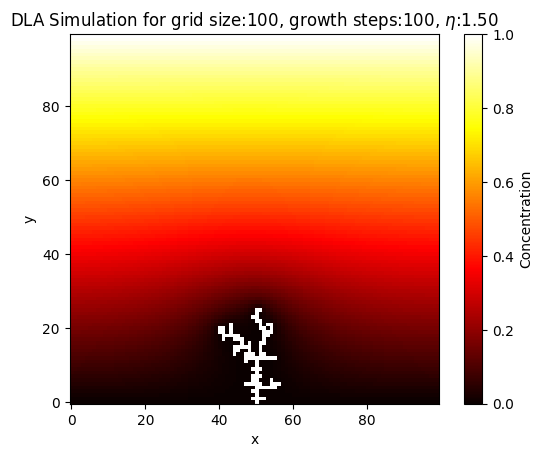

In [108]:
grid_size = 100 # grid size
initial_grid = np.zeros((grid_size,grid_size)) # initial grid
initial_grid[-1,:] = 1 # source at y = N
objects = [(0,int(grid_size/2))] # initial objects
growth_steps = 100 # number of growth steps
free_parameter = 1.5 # free parameter
final_state, final_objects = simulate_DLA(initial_grid, grid_size, objects, growth_steps, free_parameter)

# Making objects concentration 1 to visulaize the final state.
for i in range(len(final_objects)):
    final_state[final_objects[i][0], final_objects[i][1]] = 1

fig, ax = plt.subplots()
cax = ax.imshow(final_state, cmap='hot', interpolation='nearest', origin='lower')
fig.colorbar(cax, label='Concentration')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(fr'DLA Simulation for grid size:{grid_size}, growth steps:{growth_steps}, $\eta$:{free_parameter:.2f}')
plt.show()

#### Monte Carlo DLA

In [157]:
def monte_carlo_DLA(initial_grid, grid_size, objects, growth_steps, sticking_probability):
    total_steps = 0
    for i in range(growth_steps):
        print_progress_bar(i + 1, growth_steps, prefix='steps:', suffix='Complete', length=50)
        # find the neighbors of growth objects
        neighbors = []
        for i in objects:
            neighbors += [(i[0]-1,i[1]), (i[0]+1,i[1]), (i[0],(i[1]+1)%grid_size), (i[0],(i[1]-1)%grid_size)]
        # find the growth objects.
        # chose a random point on the top boundary.
        random_walker = (len(initial_grid)-1, np.random.choice(grid_size))
        attached = False
        while not attached:
            possible_steps = [(random_walker[0]-1, random_walker[1]), (random_walker[0]+1, random_walker[1]), (random_walker[0], (random_walker[1]+1)%grid_size), (random_walker[0], (random_walker[1]-1)%grid_size)]
            random_walker_new = possible_steps[np.random.choice(len(possible_steps))]
            # create new random walker if it hits the boundary.
            if random_walker_new[0] == -1 or random_walker_new[0] == grid_size:
                random_walker = (len(initial_grid)-1, np.random.choice(grid_size))
            elif random_walker_new not in objects:
                random_walker = random_walker_new
            total_steps += 1
            if random_walker in neighbors and np.random.rand() < sticking_probability:
                attached = True
        objects.append(random_walker)

    steady_state_monte_carlo = diffusion_SOR(initial_grid, grid_size, objects, omega=1.95, tol=1e-5, max_iter=10000)

    return steady_state_monte_carlo, objects
            

#### Test run

steps: |██████████████████████████████████████████████████| 100.0% Complete


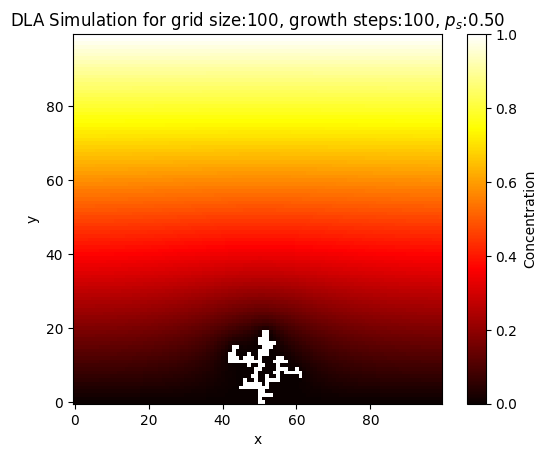

In [159]:
grid_size = 100 # grid size
initial_grid = np.zeros((grid_size,grid_size)) # initial grid
initial_grid[-1,:] = 1 # source at y = N
objects = [(0,int(grid_size/2))] # initial objects
growth_steps = 100 # number of growth steps
free_parameter = 1.5 # free parameter
sticking_probability = 0.5 # sticking probability
final_state, final_objects = monte_carlo_DLA(initial_grid, grid_size, objects, growth_steps, sticking_probability)

# Making objects concentration 1 to visulaize the final state.
for i in range(len(final_objects)):
    final_state[final_objects[i][0], final_objects[i][1]] = 1

fig, ax = plt.subplots()
cax = ax.imshow(final_state, cmap='hot', interpolation='nearest', origin='lower')
fig.colorbar(cax, label='Concentration')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(fr'DLA Simulation for grid size:{grid_size}, growth steps:{growth_steps}, $p_s$:{sticking_probability:.2f}')
plt.show()

#### Reaction-Diffusion